In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from sklearn.cluster import SpectralClustering
from scipy.linalg import eigh

# Import, transform, and merge data

In [2]:
# read files
df_private_credit_import = pd.read_csv("PrivateCredit_relative.csv")
df_trade_import = pd.read_csv("Trade_2024.csv")
df_account_import = pd.read_csv("Account_Balance_2024.csv")

In [3]:
# turn numeric
df_private_credit_import['2024 [YR2024]'] = pd.to_numeric(
    df_private_credit_import['2024 [YR2024]'],
    errors='coerce'
)
df_trade_import['2024 [YR2024]'] = pd.to_numeric(
    df_trade_import['2024 [YR2024]'],
    errors='coerce'
)
df_account_import['2024 [YR2024]'] = pd.to_numeric(
    df_account_import['2024 [YR2024]'],
    errors='coerce'
)

In [4]:
# define list of relevant columns
relevant_columns = ['Country Name', '2024 [YR2024]']

In [5]:
# read and import control file
df_control_import = pd.read_csv("GDP_percapita.csv").iloc[:217]

df_control_import['2024 [YR2024]'] = pd.to_numeric(
    df_control_import['2024 [YR2024]'],
    errors='coerce'
)

df_control_import = df_control_import.loc[:, relevant_columns]

df_control = df_control_import.rename(columns = {
    'Country Name': 'COUNTRY',
    '2024 [YR2024]': 'GDP per capita (C)'
})

In [6]:
# remove non-country rows
df_private_credit_import = df_private_credit_import.iloc[:217]
df_trade_import = df_trade_import.iloc[:217]
df_account_import = df_account_import[:217]

In [7]:
# remove irrelevant columns
df_private_credit_import = df_private_credit_import.loc[:, relevant_columns]
df_trade_import = df_trade_import.loc[:, relevant_columns]
df_account_import = df_account_import.loc[:, relevant_columns]

In [8]:
# rename columns
df_private_credit = df_private_credit_import.rename(columns = {
    'Country Name': 'COUNTRY',
    '2024 [YR2024]': 'Private Credit (domestic)'
})

df_trade = df_trade_import.rename(columns = {
    'Country Name': 'COUNTRY',
    '2024 [YR2024]': 'Trade Openness'
})

df_account = df_account_import.rename(columns = {
    'Country Name': 'COUNTRY',
    '2024 [YR2024]': 'Account Balance'
})

In [9]:
# merging data
df_merged = pd.merge(df_private_credit, df_trade, on='COUNTRY')
df_data = pd.merge(df_merged, df_account, on='COUNTRY')
df_data_control = pd.merge(df_data, df_control, on='COUNTRY')

In [10]:
# fill NaN for '..'
data_columns = ['Private Credit (domestic)', 'Trade Openness', 'Account Balance']
control_columns = ['Private Credit (domestic)', 'Trade Openness', 'Account Balance', 'GDP per capita (C)']

df_data = df_data.loc[:, data_columns].replace('..', np.nan)

df_data_control = df_data_control.loc[:, control_columns].replace('..', np.nan)

In [11]:
# prepare missing values comparison
mask_missing = (df_data[['Private Credit (domestic)', 'Trade Openness', 'Account Balance']]
                .isna().any(axis=1))
mask_not_missing = ~(mask_missing)

In [12]:
# drop missing values (non-trivial; GDP per capita)
df_data_missing = df_data_control[mask_missing]
df_data_not_missing = df_data_control[mask_not_missing]

control_missing = df_data_missing['GDP per capita (C)'].dropna().to_numpy()
control_not_missing = df_data_not_missing['GDP per capita (C)'].dropna().to_numpy()

In [13]:
# drop missing values
df_data = df_data.copy()
df_data = df_data.dropna()

In [18]:
# convert to array
data = df_data.to_numpy()
n = len(data)

# Normalize and Prepare Data

In [ ]:
# Compare missing and non missing values statistically

In [19]:
# scale/normalize data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Clustering

In [20]:
# compute euclidean distance, scott's bandwidth matrix, and Gaussian kernel
def euclidean_distance(x: np.ndarray, y: np.ndarray):
    if x.shape != y.shape:
        raise ValueError("Input only arrays of same shape")
    x = x.flatten()
    y = y.flatten()
    return np.sqrt(np.sum((x-y)**2))

def scotts_3D(arr: np.ndarray):
    n_samples = len(arr)
    if arr.shape != (n_samples, 3):
        raise ValueError("Only for 3D data!")
    
    arr_std = np.std(arr, axis=0)

    matrix = np.zeros((3, 3))
    for k in range(3):
        matrix[k, k] = 1 / (arr_std[k] * n_samples**(-1/7))**2
    
    return matrix

def gaussian_3D_kernel(x, y, H):
    if H.shape != (3, 3):
        raise ValueError("Bandwidth matrix out of bounds!")
    
    return np.exp(-1/2 * (x-y).T @ H @ (x-y))

In [26]:
# compute Scott's bandwidth matrix
width_matrix = scotts_3D(data)

In [35]:
# compute matrices
W = np.zeros((n, n))

for i in range(n):
  for j in range(n):
    W[i, j] = gaussian_3D_kernel(data[i], data[j], scotts_3D(data))

D = np.zeros((n,n))
for  i in range(n):
  D[i, i] = sum(W[i, :])

D_inv_sqrt = np.zeros((n,n))
for  i in range(n):
  D_inv_sqrt[i,i] = 1/(np.sqrt(D[i,i]))

L = D - W
L_norm = D_inv_sqrt @ L @ D_inv_sqrt
lambdas, v = eigh(L_norm)

In [44]:
# Spectral Clustering
clustering = SpectralClustering(n_clusters= 7, affinity='precomputed')
labels = clustering.fit_predict(W)

# Visualizations and Results

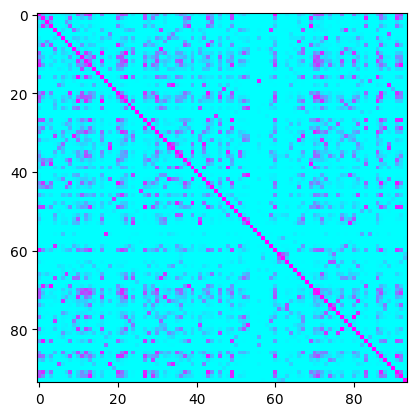

In [33]:
# show similarity matrix
plt.imshow(W, interpolation='nearest', cmap='cool')

plt.show()

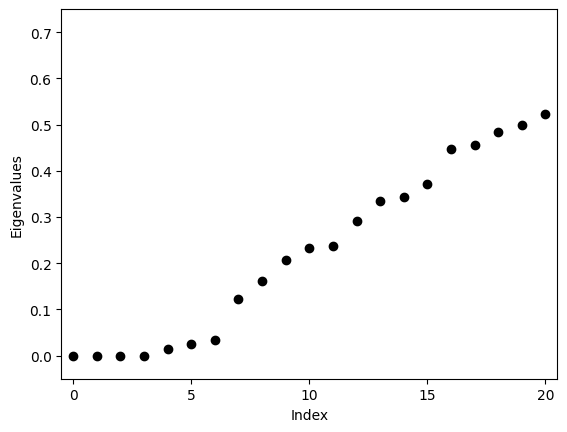

gap1 is 1.0893157943178966e-09
gap2 is 8.291963056776727e-07
gap3 is 6.471977966663312e-05
gap4 is 0.013360161328669296
gap5 is 0.011017886917710218
gap6 is 0.010060828577674319
gap7 is 0.08768760455915792
gap8 is 0.04032239713250163
gap9 is 0.04449304623833161
gap10 is 0.025202154378436203


In [43]:
# plot eigenvalues and show eigengaps
indices = np.arange(n)
constant = np.zeros(n)

plt.scatter(indices, lambdas, marker = 'o', color = 'black')
plt.xlabel('Index')
plt.ylabel('Eigenvalues')
plt.xlim(-0.5, 20.5)
plt.ylim(-0.05, 0.75)

plt.gca().xaxis.get_major_locator().set_params(integer=True)
plt.show()

eigengaps = [lambdas[k] - lambdas[k-1] for k in range(1,11)]
for k, gap in enumerate(eigengaps, start=1):
  print(f"gap{k} is {gap}")

In [45]:
df_data['Labels'] = labels

In [47]:
df_data.sort_values("Labels")

,Private Credit (domestic),Trade Openness,Account Balance,Labels
1,34.059781,79.454636,-2.395546,0
2,19.034078,40.134574,-1.022499,0
5,7.277022,50.842231,6.247440,0
7,15.117678,27.929761,0.893118,0
10,129.317350,47.145381,-1.978112,0
...,...,...,...,...
51,56.657763,190.402871,-8.159070,6
145,53.926504,136.324876,-2.100204,6
139,82.332094,153.830652,9.129968,6
174,35.416507,155.657929,4.550868,6


# Test code, review files

In [ ]:
df_data_missing

In [21]:
stat, p = mannwhitneyu(control_not_missing, control_missing, alternative='two-sided')
print('Test statistic:', stat)
print('p-value:', p)

Test statistic: 5800.0
p-value: 0.001930745924554225


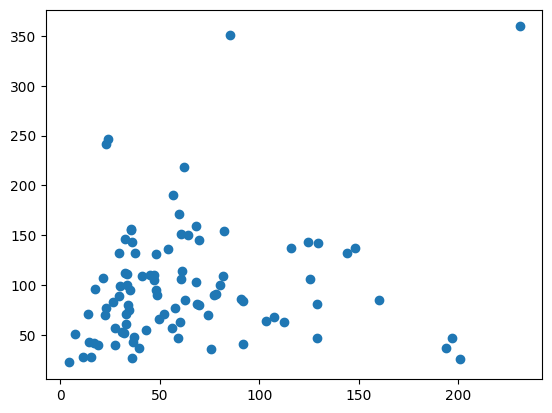

In [28]:
plt.scatter(data[:, 0], data[:, 1])

plt.show()

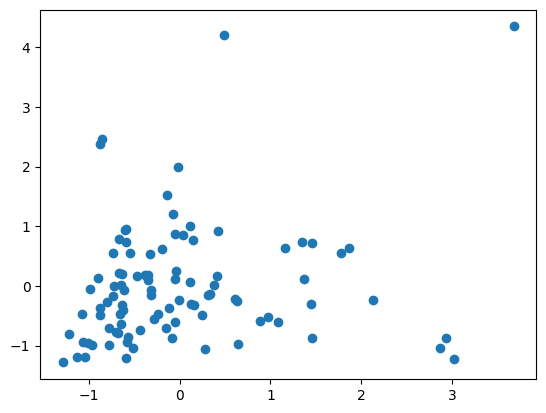

In [29]:
plt.scatter(data_normalized[:, 0], data_normalized[:, 1])

plt.show()

In [22]:
x_test = data_normalized[3, :]
y_test = data_normalized[27, :]

print(euclidean_distance(x_test, y_test))

0.7464925371780637


In [21]:
print(data[3, :])

[15.11767784 27.92976085  0.89311842]
